In [17]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

GPU is on, import libraries

In [0]:
import keras
import numpy as np
import pandas as pd
from PIL import Image, ImageChops

from keras.applications.vgg16 import preprocess_input
from keras_preprocessing.image import ImageDataGenerator

def append_ext(fn):
    return fn+".jpg"

def extract_ext(fn):
    fn = fn.replace('.jpg', "")
    return fn

def remove_blackborders(img):
    bg = Image.new(img.mode, img.size, img.getpixel((0,0)))
    diff = ImageChops.difference(img, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return img.crop(bbox)

Import data (id, category) from csv file

In [19]:
# from google.colab import drive
# drive.mount('/content/drive')
df=pd.read_csv(r'/content/drive/My Drive/skincancerdata/Train.csv')
df['Category'] = df['Category'].astype(str) 
df['Id'] = df['Id'].apply(append_ext)
df.head()

,Id,Category
0,Image_1.jpg,2
1,Image_2.jpg,2
2,Image_3.jpg,5
3,Image_4.jpg,2
4,Image_5.jpg,1


Plot the data of csv file (Id, Category)

As seen in the graph class 2 has more samples compared to other classes which causes an imbalance in the data 

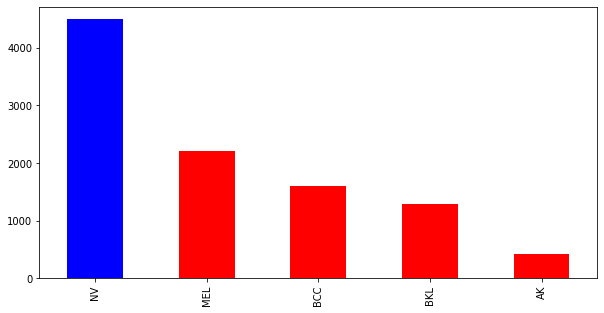

In [0]:
import matplotlib.pyplot as plt
df_new = df.copy()
type_dict ={'1' : 'MEL', '2' : 'NV', '3' : 'BCC', '4' : 'AK', '5':'BKL'} 
df_new['Names'] = df_new['Category'].map(type_dict) 
# print(df_new)


fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df_new['Names'].value_counts().plot(kind='bar', ax=ax1,color=['blue', 'red', 'red', 'red', 'red'])

Handle unbalanced data by assigining class weights that affects the penalty rate

Implemented it while fitting the model, it decreased the accuracy


In [0]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df['Category']),
                                                 df['Category'])
class_weight_dict = dict(enumerate(class_weights))

Remove black borders from images, then resize them
Save the processed images in another directory

In [0]:
import os, os.path

trainImage_direct = "/content/drive/My Drive/skincancerdata/traindata_image/"
testImage_direct = "/content/drive/My Drive/skincancerdata/testdata_image/"

trainCrop_direct = "/content/drive/My Drive/skincancerdata/trainCroppedImage/"

# # crop black borders from images in training dataset 
for i in range(1,10001):
  img = Image.open(trainImage_direct+"Image_"+str(i)+".jpg")
  width, height = img.size
  if width == 1024:
    if remove_blackborders(img) is not None: 
      img = remove_blackborders(img)

  img.save(os.path.join(trainCrop_direct, "Image_"+str(i)+".jpg"))

In [0]:
trainProcessed_direct = "/content/drive/My Drive/skincancerdata/trainProcessedImage/"

# # resize images in order to make them in equal dimensions
for i in range(1,10001):
  img = Image.open(trainCrop_direct+"Image_"+str(i)+".jpg")
  newsize = (256,256)
  img = img.resize(newsize)
  img.save(os.path.join(trainProcessed_direct, "Image_"+str(i)+".jpg"))

Generated the data and merge the csv file with images, then split as training and validation data

In [20]:
train_datagen = ImageDataGenerator(validation_split=0.25,
                                    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.2,
                                    horizontal_flip=True, vertical_flip=True, preprocessing_function=preprocess_input)
                                                    
train_generator=train_datagen.flow_from_dataframe(dataframe=df,
      directory="/content/drive/My Drive/skincancerdata/trainProcessedImage",  x_col="Id", y_col="Category", subset="training",
      batch_size=32, seed=42, shuffle=True, class_mode="sparse", target_size=(256,256), interpolation="nearest")

valid_generator=train_datagen.flow_from_dataframe(dataframe=df,
      directory="/content/drive/My Drive/skincancerdata/trainProcessedImage",  x_col="Id", y_col="Category",subset="validation", 
      batch_size=32, seed=42, shuffle=True,class_mode="sparse", target_size=(256,256))


Found 7500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


Visualize the image data

x (32, 32, 32, 3) float32 -0.48501962 0.59239614
y (32,) float32 0.0 4.0


Text(0.5, 1.0, 'images')

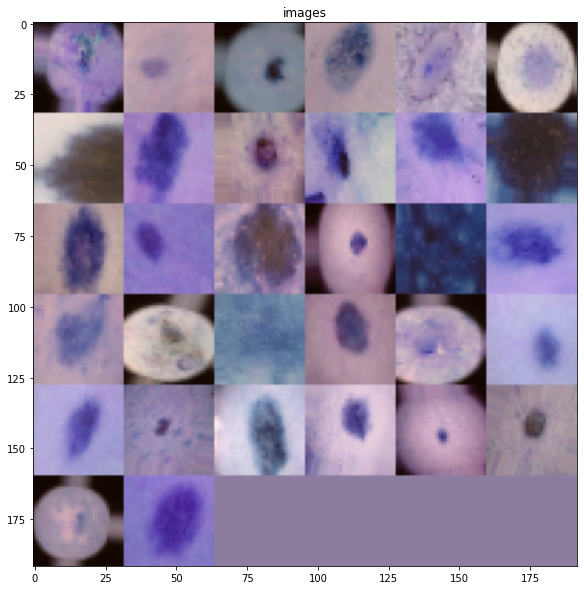

In [0]:
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
t_x, t_y = next(train_generator)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1) = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(montage_rgb((t_x-t_x.min())/(t_x.max()-t_x.min()))[:, :, ::1])
ax1.set_title('images')

Implement CNN model (It is the baseline, do not run the model cell if you will implement the transfer learning)

In [0]:
from keras.models import Sequential, Model
from keras import optimizers
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras import regularizers

To run CNN model you should set target_size=(32,32) while generating train and validation data and remove preprocessing_function, add rescale=1./255 instead at ImageDataGenerator

In [23]:
model = tf.keras.models.Sequential([                             
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', input_shape=(32,32,3)),### Conv2D layer
  tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=1,padding='same'),### MaxPooling2D layer
  tf.keras.layers.Conv2D(filters=128,kernel_size=3, strides=1, activation='relu'),### Conv2D layer
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),### MaxPooling2D layer
  tf.keras.layers.Conv2D(filters=256,kernel_size=3, strides=1, activation='relu'),### Conv2D layer (additional)
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),### MaxPooling2D layer
  tf.keras.layers.Flatten(),### Flatten
  tf.keras.layers.Dense(64, activation='relu'), ###Dense
  tf.keras.layers.Dense(5, activation='softmax'),### Dense softmax
])


model.compile(optimizer = "adam",
loss="sparse_categorical_crossentropy", metrics=["accuracy"])
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15)

Epoch 1/15
234/234 [==============================] - 162s 693ms/step - loss: 1.2686 - accuracy: 0.4830 - val_loss: 1.1817 - val_accuracy: 0.5212
Epoch 2/15
234/234 [==============================] - 33s 140ms/step - loss: 1.1737 - accuracy: 0.5187 - val_loss: 1.1435 - val_accuracy: 0.5413
Epoch 3/15
234/234 [==============================] - 32s 136ms/step - loss: 1.1472 - accuracy: 0.5337 - val_loss: 1.1103 - val_accuracy: 0.5501
Epoch 4/15
234/234 [==============================] - 32s 135ms/step - loss: 1.1213 - accuracy: 0.5473 - val_loss: 1.1280 - val_accuracy: 0.5296
Epoch 5/15
234/234 [==============================] - 32s 137ms/step - loss: 1.1075 - accuracy: 0.5487 - val_loss: 1.0823 - val_accuracy: 0.5657
Epoch 6/15
234/234 [==============================] - 32s 135ms/step - loss: 1.0996 - accuracy: 0.5545 - val_loss: 1.0712 - val_accuracy: 0.5681
Epoch 7/15
234/234 [==============================] - 31s 134ms/step - loss: 1.0849 - accuracy: 0.5636 - val_loss: 1.0699 - val_a

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


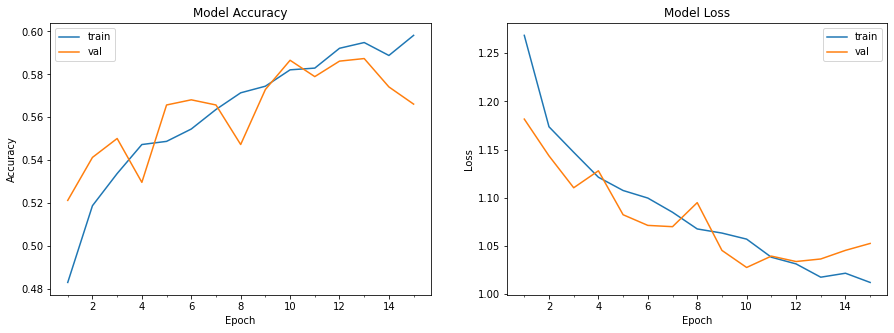

In [27]:
import matplotlib.pyplot as plt

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(history)

Implement transfer learning by using the pretrained model VGG16

In [0]:
from keras.applications.vgg16 import VGG16
#Implement the pre-trained model with imagenet dataset
HEIGHT = 256
WIDTH = 256

base_model = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [0]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for i in range(len(base_model.layers)-1):  #keep pre-learned weights
        base_model.layers[i].trainable = False

    x = base_model.layers[-1].output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        #x = Dense(fc, activation='relu')(x) 
        x = Dense(fc, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

#FC_LAYERS = [1024, 1024]
FC_LAYERS = [512, 256]
#FC_LAYERS = [512, 512]
dropout = 0.5
#dropout = 0.3

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=5)

In [0]:
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

NUM_EPOCHS = 15
BATCH_SIZE = 8
num_train_images = 7500
num_valid_images = 2500
early_stopping_patience = 5

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath="/content/drive/My Drive/skincancerdata/checkpoints/"+ "Vgg16" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["val_loss"], verbose=1, mode='max')
early_stopper = EarlyStopping(monitor = 'val_loss', patience = early_stopping_patience)
callbacks_list = [checkpoint, early_stopper]


history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch= num_train_images//BATCH_SIZE,
                                       validation_data=valid_generator,
                                       validation_steps= num_valid_images//BATCH_SIZE, 
                                       shuffle=True, callbacks=callbacks_list)

Epoch 1/15
937/937 [==============================] - 197s 210ms/step - loss: 2.7306 - accuracy: 0.4004 - val_loss: 0.7709 - val_accuracy: 0.5192

Epoch 00001: saving model to /content/drive/My Drive/skincancerdata/checkpoints/ResNet50_model_weights.h5
Epoch 2/15
937/937 [==============================] - 181s 193ms/step - loss: 1.7180 - accuracy: 0.4221 - val_loss: 0.7403 - val_accuracy: 0.5285

Epoch 00002: saving model to /content/drive/My Drive/skincancerdata/checkpoints/ResNet50_model_weights.h5
Epoch 3/15
937/937 [==============================] - 180s 192ms/step - loss: 1.4487 - accuracy: 0.4414 - val_loss: 0.9045 - val_accuracy: 0.5285

Epoch 00003: saving model to /content/drive/My Drive/skincancerdata/checkpoints/ResNet50_model_weights.h5
Epoch 4/15
937/937 [==============================] - 180s 192ms/step - loss: 1.3641 - accuracy: 0.4517 - val_loss: 0.9361 - val_accuracy: 0.5217

Epoch 00004: saving model to /content/drive/My Drive/skincancerdata/checkpoints/ResNet50_model

Genarate test input

In [0]:
testdf=pd.read_csv(r'/content/drive/My Drive/skincancerdata/Test.csv')
testdf['Id'] = testdf['Id'].apply(append_ext)

testdf.head()

,Id,Category
0,Image_10001.jpg,0
1,Image_10002.jpg,0
2,Image_10003.jpg,0
3,Image_10004.jpg,0
4,Image_10005.jpg,0


In [0]:
#use model for cnn
#use finetune_model for transfer learning 

test_datagen=ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_dataframe(dataframe=testdf,
    directory="/content/drive/My Drive/skincancerdata/testProcessedImage", x_col="Id", y_col=None, batch_size=16,
    seed=42, shuffle=False, class_mode=None, target_size=(300,300))

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
finetune_model.evaluate(valid_generator, steps=STEP_SIZE_TEST) #evaluate the model with validation dataset

Found 5000 validated image filenames.
312/312 [==============================] - 189s 607ms/step


[1.498685359954834, 0.5412121415138245]

Predict the output

In [0]:
#use model for cnn
#use finetune_model for transfer learning 

test_generator.reset() #reset the generator to get the inputs in order
pred=finetune_model.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

156/156 [==============================] - 1106s 7s/step


Map predicted labels with their unique ids such as their filenames to find out what is found for which image

In [0]:
predicted_class_indices=np.argmax(pred,axis=1) #predicted labels

categories = (train_generator.class_indices)
categories = dict((v,k) for k,v in categories.items())
predictions = [categories[k] for k in predicted_class_indices]

Save the results to a CSV file

In [0]:
filenames=test_generator.filenames

# print(len(filenames), len(predictions))

results=pd.DataFrame.from_dict({"Id":filenames,
                      "Category":predictions}, orient='index')
results.replace(to_replace=[None], value="2", inplace=True)
resultsTrans = results.transpose()
resultsTrans['Id'] = resultsTrans['Id'].apply(extract_ext)
resultsTrans.head()
resultsTrans.to_csv("results.csv",index=False)